# Benchmarking new PICS implementation

The objective of this notebook is to compare the new implementation of PICS estimated on GWAS Catalog associations using gnomAD LD reference, against the previous implementation using 1000 genomes phase III LD reference. 

1. Describe the new dataset
    - Number of signals covered.
    - Number of signals dropped.
2. Copare with old PICS Dataset.
    - Δ number of covered study (not particularly relevant given updates in GWAS Catalog)
    - Δ number of covered peaks from studies found in the old release - might see increased coverage.
    - Δ in the recovered credible set: number of variants, change in posterior probability.
    - Δ in the average number of credible sets.

    

In [1]:
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql import SparkSession, DataFrame, Column
from pyspark.sql.window import Window

spark = SparkSession.builder.getOrCreate()
# spark.stop()
type(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/01/16 12:34:40 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/01/16 12:34:40 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/01/16 12:34:40 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/01/16 12:34:40 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


pyspark.sql.session.SparkSession

## 1 Describing the new dataset

1. Study count.
2. Association count.
3. Studies split.
4. Associations not resolved in LD set.

In [3]:
new_study_locus = (
    spark.read.parquet("gs://genetics_etl_python_playground/XX.XX/output/python_etl/parquet/pics_credible_set/")
    .withColumn('pics_99_perc_credset', f.when(f.col('tagVariantId').isNull(), False).otherwise(f.col('pics_99_perc_credset')))
    .withColumn(
        'hasResolvedCredibleSet', 
        f.when(
            f.array_contains(
                f.collect_set(f.col('pics_99_perc_credset')).over(Window.partitionBy('studyId', 'variantId')), 
                True
            ),
            True
        ).otherwise(False)
    )
    .persist()
)


new_study_locus.printSchema()
new_study_locus.show(1, False, True)
print(new_study_locus.count())

23/01/09 10:24:06 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


root
 |-- chromosome: string (nullable = true)
 |-- variantId: string (nullable = true)
 |-- studyId: string (nullable = true)
 |-- position: string (nullable = true)
 |-- referenceAllele: string (nullable = true)
 |-- alternateAllele: string (nullable = true)
 |-- pValueMantissa: float (nullable = true)
 |-- pValueExponent: integer (nullable = true)
 |-- beta: string (nullable = true)
 |-- beta_ci_lower: double (nullable = true)
 |-- beta_ci_upper: double (nullable = true)
 |-- odds_ratio: string (nullable = true)
 |-- odds_ratio_ci_lower: double (nullable = true)
 |-- odds_ratio_ci_upper: double (nullable = true)
 |-- qualityControl: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tagVariantId: string (nullable = true)
 |-- R_overall: double (nullable = true)
 |-- pics_mu: double (nullable = true)
 |-- pics_std: double (nullable = true)
 |-- pics_postprob: double (nullable = true)
 |-- pics_95_perc_credset: boolean (nullable = true)
 |-- pics_99_perc_cred

In [4]:
study_count = new_study_locus.select('studyId').distinct().count()
association_count = new_study_locus.select('studyId', 'variantId').distinct().count()
association_w_credible_set = new_study_locus.filter(f.col('hasResolvedCredibleSet')).persist()
credible_set_count = association_w_credible_set.select('studyId', 'variantId').distinct().count()
failed_w_ld = (
    new_study_locus
    # Selecting good associations without credible sets:
    .filter(
        (~f.col('hasResolvedCredibleSet')) & 
        (f.size(f.col('qualityControl'))>0)
    )
    # Get associations:
    .select('studyId', 'variantId')
    .distinct()
    .count()
)
good_association_count = (
    association_w_credible_set
    # Drop failed associations:
    .filter(f.size(f.col('qualityControl')) == 0)
    .select('studyId', 'variantId')
    .distinct()
    .count()
)

print(f'Study count: {study_count}')
print(f'Association (unique study/variant pairs) count: {association_count}')
print(f'Associations with resolved credible set: {credible_set_count} ({round(credible_set_count/association_count*100, 1)}%)')
print(f'Number of good (non-flagged) associations without resolved credible set: {failed_w_ld} ({round(failed_w_ld/association_count*100, 1)}%)')
print(f'Number of good (non-flagged) associations with resolved credible set: {good_association_count} ({round(good_association_count/association_count*100, 1)}%)')


Study count: 35990
Association (unique study/variant pairs) count: 433191
Associations with resolved credible set: 355864 (82.1%)
Number of good (non-flagged) associations without resolved credible set: 77237 (17.8%)
Number of good (non-flagged) associations with resolved credible set: 244746 (56.5%)


## Non-inependent associations

In [7]:
(
    new_study_locus
    .select('studyId', 'variantId', f.explode_outer(f.col('qualityControl')).alias('qualityControl'))
    .filter(f.col('qualityControl').contains('explained'))
    .show(truncate=False)
)

+------------+----------------+------------------------------------------+
|studyId     |variantId       |qualityControl                            |
+------------+----------------+------------------------------------------+
|GCST001158  |4_154586438_T_C |Association explained by: 4_154621096_C_T |
|GCST001931  |20_32849801_G_A |Association explained by:                 |
|GCST002767  |11_120377633_C_T|Association explained by: 11_120421768_T_C|
|GCST003262_1|15_78528674_G_A |Association explained by: 15_78545331_C_T |
|GCST003262_1|15_78606590_C_G |Association explained by: 15_78575140_A_C |
|GCST003262_1|3_84957714_C_T  |Association explained by:                 |
|GCST003262_1|3_85421211_G_T  |Association explained by:                 |
|GCST003262_1|4_144512423_C_A |Association explained by: 4_144524627_A_T |
|GCST003264  |4_104903977_G_A |Association explained by:                 |
|GCST003264  |4_104904293_C_T |Association explained by:                 |
|GCST003264  |4_104946758

In [37]:
def _neglog_p(p_value_mantissa: Column, p_value_exponent: Column) -> Column:
    """Compute the negative log p-value.

    Args:
        p_value_mantissa (Column): P-value mantissa
        p_value_exponent (Column): P-value exponent

    Returns:
        Column: Negative log p-value

    Examples:
        >>> d = [(1, 1), (5, -2), (1, -1000)]
        >>> df = spark.createDataFrame(d).toDF("p_value_mantissa", "p_value_exponent")
        >>> df.withColumn("neg_log_p", _neglog_p(f.col("p_value_mantissa"), f.col("p_value_exponent"))).show()
        +----------------+----------------+------------------+
        |p_value_mantissa|p_value_exponent|         neg_log_p|
        +----------------+----------------+------------------+
        |               1|               1|              -1.0|
        |               5|              -2|1.3010299956639813|
        |               1|           -1000|            1000.0|
        +----------------+----------------+------------------+
        <BLANKLINE>
    """
    return -1 * (f.log10(p_value_mantissa) + p_value_exponent)


up_to_test = (
    new_study_locus
    .filter(
        (f.col('chromosome') == 'X') &
        (f.col('studyId') == 'GCST004860')
    )
    .select(
        'studyId',
        'variantId',
        _neglog_p(f.col('pValueMantissa'), f.col('pValueExponent')).alias('negLogP'),
        'qualityControl',
    )
    .distinct().persist()
)

test_df = (
    up_to_test
    .select(
        f.split(f.col('variantId'), '_').getItem(1).alias('position').cast(t.IntegerType()),
        'negLogP',
        f.when(f.concat_ws(', ', 'qualityControl').contains('explain'), True).otherwise(False).alias('qc')
    )
    .toPandas()
)

up_to_test.orderBy('negLogP').show(50, truncate=False)


23/01/09 13:14:02 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


+----------+---------------+------------------+----------------------------------------------------------------------------------------------------------+
|studyId   |variantId      |negLogP           |qualityControl                                                                                            |
+----------+---------------+------------------+----------------------------------------------------------------------------------------------------------+
|GCST004860|X_107210017_G_A|5.045757490560675 |[Subsignificant p-value, Association explained by: X_106816683_C_T]                                       |
|GCST004860|X_106585073_C_T|5.096910013008056 |[Subsignificant p-value]                                                                                  |
|GCST004860|X_107174072_T_C|5.154901959985743 |[Subsignificant p-value, Credible set not resolved]                                                       |
|GCST004860|X_107294522_C_T|5.221848749616356 |[Subsignificant p-value

In [47]:
columns = ['chromosome', 'position', 'referenceAllele', 'alternateAllele']
variants = spark.createDataFrame([x['variantId'].split('_') for x in up_to_test.select('variantId').distinct().collect()], columns)

ld_index_file = 'gs://genetics_etl_python_playground/input/ld/gnomad_r2.1.1.nfe.common.ld.variant_indices.parquet'
rows = (
    variants
    .join(spark.read.parquet(ld_index_file), on=columns, how='left')
    .filter(f.col('idx').isNotNull())
    .select('idx')
    .collect()
)

indices = [
    int(x['idx']) for x in rows
]

indices
# variants

[14052215,
 14052215,
 14052215,
 14052215,
 14052284,
 14051864,
 14053044,
 14053353,
 14051424,
 14052114,
 14052373,
 14052665,
 14052665,
 14052665,
 14051080,
 14052107,
 14052107,
 14052107,
 14052107,
 14052107,
 14052326,
 14052902,
 14052941,
 14052027,
 14052253,
 14053210,
 13991184,
 14051521,
 14051521,
 14051521,
 14051755,
 14051806,
 14051806,
 14051806,
 14053066,
 14051974,
 14052176,
 14052176,
 14052176,
 14052176,
 14052191,
 14051689,
 14052020,
 14053054,
 14051973,
 14052087,
 14052458,
 14052655,
 14053111,
 14052299]

In [51]:
(
    variants
    .join(spark.read.parquet(ld_index_file), on=columns, how='left')
    # .filter(f.col('idx').isNotNull())
    # .select('idx')
    # .collect()
    .orderBy('idx')
    .show(60)
)

+----------+---------+---------------+---------------+--------+---------+--------+
|chromosome| position|referenceAllele|alternateAllele|     idx|start_idx|stop_idx|
+----------+---------+---------------+---------------+--------+---------+--------+
|         X|107158099|              G|              C|    null|     null|    null|
|         X|107296378|              T|              C|    null|     null|    null|
|         X|107296299|              T|              C|    null|     null|    null|
|         X|107174072|              T|              C|    null|     null|    null|
|         X| 87315170|              C|              T|13991184| 13988101|13993719|
|         X|106050079|              C|              T|14051080| 14050241|14051758|
|         X|106313139|              G|              A|14051424| 14050669|14052084|
|         X|106375530|              T|              C|14051521| 14050770|14052159|
|         X|106375530|              T|              C|14051521| 14050770|14052161|
|   

Get the number of associations with not credible sets:

Number of non-independent associations: 19
Number of independent associations: 19


<AxesSubplot:xlabel='position', ylabel='negLogP'>

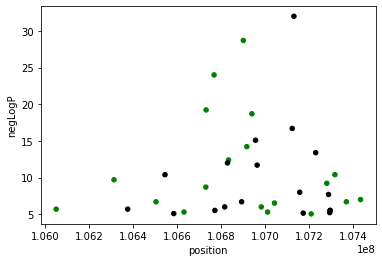

In [34]:
print(f'Number of non-independent associations: {len(test_df.loc[test_df.qc])}')
print(f'Number of independent associations: {len(test_df.loc[~test_df.qc])}')

(
    test_df
    .query('position > 9E7')
    .assign(color=lambda df: df.qc.apply(lambda x: 'green' if x is True else 'black'))
    .plot.scatter('position', 'negLogP', c='color')
)

#

In [75]:
unresolved = (
    new_study_locus
    .filter((~f.col('pics_99_perc_credset')) & ~f.col('hasResolvedCredibleSet'))
    # .filter((f.col("studyId") == 'GCST001782') & (f.col('variantId') == '16_134391_T_G'))
    # .select('studyId', 'variantId', 'tagVariantId', 'pics_99_perc_credset', 'pValueMantissa', 'pValueExponent')
    # .show(20)
    .persist()
)

unresolved_count = unresolved.count()
ld_failed_count = (
    unresolved
    .filter(f.size(f.col('qualityControl')) == 1)
    .count()
)
gnomad_mapping_failed_count = (
    unresolved
    .filter(f.array_contains(f.col('qualityControl'), 'No mapping in GnomAd'))
    .distinct()
    .count()
)
gnomad_mapping_failed_w_rsid_count = (
    unresolved
    .filter(
        f.array_contains(f.col('qualityControl'), 'No mapping in GnomAd') &
        f.lower(f.col('variantId')).contains('rs')
    )
    .distinct()
    .count()
)
print(f'Number of associations with failed credible sets: {unresolved_count} ({round(unresolved_count/association_count*100, 1)}%)')
print(f'Number of associations with good mapping, but failed LD: {ld_failed_count} ({round(ld_failed_count/association_count*100, 1)}%)')
print(f'Associations with failed GnomAD mapping: {gnomad_mapping_failed_count} ({round(gnomad_mapping_failed_count/association_count*100, 1)}%)')
print(f'Associations with failed GnomAD mapping, with rsId: {gnomad_mapping_failed_w_rsid_count} ({round(gnomad_mapping_failed_w_rsid_count/association_count*100, 1)}%)')

Number of associations with failed credible sets: 15791 (100.1%)
Number of associations with good mapping, but failed LD: 11167 (70.8%)
Associations with failed GnomAD mapping: 0 (0.0%)
Associations with failed GnomAD mapping, with rsId: 0 (0.0%)


Focusing only on the actual credible sets.

In [20]:
# Thu
credible_sets = new_study_locus.filter(f.col('pics_99_perc_credset')).persist()
resolved_assoc_count = credible_sets.select('studyId', 'variantId').distinct().count()
resolved_study_count = credible_sets.select('studyId').distinct().count()
lead_tag_pair_count = credible_sets.select('studyId', 'variantId', 'tagVariantId').distinct().count()

grouped_credset_pdf = credible_sets.groupBy('studyId', 'variantId').count().toPandas()

print(f'Number of resolved credible sets: {resolved_assoc_count}')
print(f'Studies with resolved credible sets: {resolved_study_count}')
print(f'Number of lead/tag pairs: {lead_tag_pair_count}')



Number of resolved credible sets: 392105
Studies with resolved credible sets: 34169
Number of lead/tag pairs: 19240869


<AxesSubplot:>

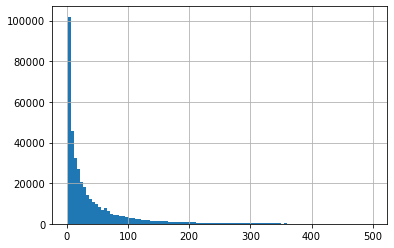

In [21]:
grouped_credset_pdf.query('count < 500')['count'].hist(bins=100)

In [22]:
median_credset_size = grouped_credset_pdf['count'].median()
credsets_with_single = len(grouped_credset_pdf.query('count == 1'))

print(f'Credible sets with only one variant: {credsets_with_single} ({round(credsets_with_single/len(grouped_credset_pdf)*100, 1)})%')
print(f'Median size of credible sets: {median_credset_size}')

Credible sets with only one variant: 38604 (9.8)%
Median size of credible sets: 18.0


In [23]:
credible_sets.groupBy('studyId', 'variantId').count().filter(f.col('count') > 1000).orderBy('count', ascending=False).show(30)

+-------------+----------------+-----+
|      studyId|       variantId|count|
+-------------+----------------+-----+
|   GCST007065| 11_55736589_G_A| 4071|
| GCST90095190| 17_45913906_A_G| 3858|
| GCST90095190| 17_46055092_G_A| 3855|
| GCST90095190| 17_45609706_G_A| 3764|
| GCST000996_1| 11_55368743_C_T| 3727|
|   GCST001482| 17_45900461_C_T| 3658|
| GCST90095190| 17_45468691_G_T| 3637|
| GCST90018982| 17_45759587_A_C| 3631|
| GCST90018996| 17_46112544_A_G| 3626|
| GCST90018908| 17_46253848_T_C| 3589|
| GCST003174_1| 17_46286843_C_T| 3562|
|   GCST003174| 17_46286843_C_T| 3559|
| GCST90018863| 17_46253848_T_C| 3543|
| GCST90011770| 17_45948522_C_A| 3538|
| GCST90095125| 17_46142465_T_A| 3524|
| GCST90095181| 17_45957209_T_C| 3520|
| GCST90095180| 17_45957209_T_C| 3520|
| GCST90095132| 17_45794616_C_T| 3511|
| GCST009540_6|17_46036725_CT_C| 3483|
| GCST001651_9| 17_46257341_G_A| 3470|
|GCST010281_14| 17_45841702_G_T| 3465|
|   GCST004414| 17_45489971_C_G| 3460|
| GCST90092852| 17_462908

It seems there are a large number of rows in the credible set data where the `tagVariantId` is null, however there is available credible set.

In [78]:
strange_credible_set_count = (
    new_study_locus
    .filter(f.col("tagVariantId").isNull() & f.col('hasResolvedCredibleSet'))
    .distinct()
    # .show(1,False,True)
    .count()
)
strange_credible_set_count
# strange_credset = (
#     new_study_locus
#     .filter(
#         (f.col('variantId') == '16_134391_T_G') &
#         (f.col('studyId') == 'GCST001782')
#     )
#     .select('studyId', 'variantId', 'tagVariantId', 'qualityControl', 'pics_99_perc_credset', 'hasResolvedCredibleSet')
#     .show(truncate=False)
# )


# strange_credset = (
#     new_study_locus
#     .filter(
#         (f.col('variantId') == '12_122207191_C_A') &
#         (f.col('tagVariantId') == '12_122255435_A_G') &
#         (f.col('studyId') == 'GCST008702')
#     )
#     .select('studyId', 'variantId', 'tagVariantId', 'qualityControl', 'pics_99_perc_credset', 'hasResolvedCredibleSet')
#     .show(1000, truncate=False)
# )

0

## Comparing with old dataset

- Data: `gs://genetics-portal-dev-staging/v2d/220210/ld.parquet`

In [24]:
old_study_locus = (
    spark.read.parquet("gs://genetics-portal-dev-staging/v2d/220210/ld.parquet")
    .select(
        f.col('study_id').alias("studyId"), 
        f.concat_ws("_", f.col("lead_chrom"), f.col("lead_pos"), f.col("lead_ref"), f.col("lead_alt")).alias("variantId"), 
        f.concat_ws("_", f.col("tag_chrom"), f.col("tag_pos"), f.col("tag_ref"), f.col("tag_alt")).alias("tagVariantId"),
        'pics_postprob',
        'pics_95perc_credset',
        'pics_99perc_credset'
    )
    .distinct()
)
lead_tag_pair_count = old_study_locus.count()
study_count = old_study_locus.select('studyId').distinct().count()
association_count = old_study_locus.select('studyId', 'variantId').distinct().count()

print(f'Number of lead/tag count: {lead_tag_pair_count}')
print(f'NUmber of studies covered: {study_count}')
print(f'Number of associations covered: {association_count}')


Number of lead/tag count: 19406519
NUmber of studies covered: 18349
Number of associations covered: 265715


In [25]:
tag_count = old_study_locus.groupBy('studyId', 'variantId').count().persist()
median_tag_count = tag_count.toPandas()['count'].median()
single_count = tag_count.filter(f.col('count') == 1).count()
over_1000 = tag_count.filter(f.col('count') >= 1000).count()

print(f'The median number of tag size: {median_credset_size}')
print(f'Number of associations with single credible set: {single_count}')
print(f'Number of associations with more than 1000 tags set: {over_1000}')

tag_count.orderBy('count',ascending=False).show(20)

The median number of tag size: 18.0
Number of associations with single credible set: 9231
Number of associations with more than 1000 tags set: 441
+-------------+---------------+-----+
|      studyId|      variantId|count|
+-------------+---------------+-----+
|   GCST001482|17_45900461_C_T| 3685|
| GCST90018953|17_45856424_G_T| 3684|
|   GCST007692|17_45846834_C_G| 3649|
| GCST90018960|17_45761354_C_T| 3360|
| GCST90018996|17_46112544_A_G| 3348|
| GCST90091060|17_45873075_C_A| 3295|
|   GCST007328|17_45887201_A_C| 3294|
|   GCST002970|17_45846317_A_G| 3294|
|   GCST007430|17_45887201_A_C| 3294|
|   GCST001548|17_45846853_T_C| 3294|
|   GCST001126|17_45846317_A_G| 3294|
|   GCST012009|17_45862033_A_C| 3294|
|   GCST010701|17_45855805_C_T| 3294|
|   GCST006941|17_45841739_C_T| 3293|
|   GCST010002|17_45895867_C_T| 3293|
|   GCST008734|17_45834077_T_C| 3293|
|   GCST004601|17_45841730_A_G| 3293|
|   GCST008994|17_45846288_G_C| 3293|
| GCST90025948|17_45834077_T_C| 3293|
|GCST009518_66|17

### Compare credible sets

To make datasets comparable, both datasets need to updated with `studyAccession`: getting the GWAS Catalog study identifier by removing the suffix.

In [34]:
processed_new = (
    credible_sets
    # Dropping leads with sub-significant p-values:
    .filter(~f.array_contains(f.col('qualityControl'), 'Subsignificant p-value'))
    .select(
        # Unsplitting studies:
        f.split(f.col('studyId'), '_').getItem(0).alias('studyAccession'),
        'variantId', 
        'tagVariantId', 
        'pics_mu', 
        'pics_postprob', 
        'pics_95_perc_credset', 
        'pics_99_perc_credset'
    )
    .persist()
)

processed_old = (
    old_study_locus
    .select(
        # Unsplitting studies:
        f.split(f.col('studyId'), '_').getItem(0).alias('studyAccession'),
        'variantId', 
        'tagVariantId',
        'pics_postprob',
        'pics_95perc_credset',
        'pics_99perc_credset' 
    )
    .persist()
)

processed_old.show(1, False, True)

-RECORD 0-----------------------------------
 studyAccession      | GCST009358           
 variantId           | 2_139752666_T_A      
 tagVariantId        | 2_139729938_T_C      
 pics_postprob       | 0.019005571528389883 
 pics_95perc_credset | true                 
 pics_99perc_credset | true                 
only showing top 1 row



22/12/21 16:59:52 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


In [35]:
aggregated_new = (
    processed_new
    .join(processed_old.select('studyAccession').distinct(), on='studyAccession', how='right')
    .groupBy('studyAccession', 'variantId')
    .agg(f.size(f.collect_list(f.col('tagVariantId'))).alias('new_credible_set_size'))
    .persist()
)

aggregated_old = (
    processed_old
    .groupBy('studyAccession', 'variantId')
    .agg(f.size(f.collect_list(f.col('tagVariantId'))).alias('old_credible_set_size'))
    .persist()
)

credset_compare = (
    aggregated_new
    .join(aggregated_old.filter(f.col('studyAccession').startswith('GCST')), on=['studyAccession', 'variantId'], how='outer')
    .persist()
)

credset_compare.show()

22/12/21 16:59:55 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


+--------------+---------------+---------------------+---------------------+
|studyAccession|      variantId|new_credible_set_size|old_credible_set_size|
+--------------+---------------+---------------------+---------------------+
|    GCST000114|15_48099968_A_G|                   13|                   38|
|    GCST000184|18_60217517_G_A|                  233|                  214|
|    GCST000282|19_11100236_C_T|                   34|                   69|
|    GCST000679| 10_6056986_C_T|                   12|                 null|
|    GCST000817|9_136220024_G_T|                   23|                   27|
|    GCST000876|11_18349351_G_C|                    2|                    6|
|    GCST000943| 20_1960525_G_A|                 null|                    2|
|    GCST000964|13_77957479_G_A|                 null|                   47|
|    GCST000998|10_44280376_C_T|                  193|                 null|
|    GCST000998|21_34226827_C_T|                   29|                   32|

In [38]:
extra_coverage = credset_compare.filter(f.col('old_credible_set_size').isNull()).count()
lost_coverage = credset_compare.filter(f.col('new_credible_set_size').isNull()).count()
old_full_count = aggregated_old.filter(f.col('studyAccession').startswith('GCST')).count()

print(f'The number of extra credible sets covered by the new dataset: {extra_coverage} ({round(extra_coverage/old_full_count * 100, 1)}%)')
print(f'Number of lost credible sets in the new datasets: {lost_coverage} ({round(lost_coverage/old_full_count*100, 1)}%)')

extra_coverage_more = credset_compare.filter(f.col('old_credible_set_size').isNull() & (f.col('new_credible_set_size')>1)).count()

print(f'The number of extra credible sets with more than 1 tags covered by the new dataset: {extra_coverage_more} ({round(extra_coverage_more/old_full_count * 100, 1)}%)')


The number of extra credible sets covered by the new dataset: 64966 (32.9%)
Number of lost credible sets in the new datasets: 45291 (23.0%)
The number of extra credible sets with more than 1 tags covered by the new dataset: 54916 (27.9%)


In [39]:
credset_compare.filter(f.col('new_credible_set_size').isNull()).show()

+--------------+--------------------+---------------------+---------------------+
|studyAccession|           variantId|new_credible_set_size|old_credible_set_size|
+--------------+--------------------+---------------------+---------------------+
|    GCST000943|      20_1960525_G_A|                 null|                    2|
|    GCST000964|     13_77957479_G_A|                 null|                   47|
|    GCST001040|     17_37738049_G_A|                 null|                   21|
|    GCST002216|      7_73450539_A_G|                 null|                   94|
|    GCST002221|     9_133372523_G_C|                 null|                   20|
|    GCST002223|      8_19973410_C_T|                 null|                  106|
|    GCST002223|      8_20009083_C_T|                 null|                   98|
|    GCST003043|     16_11271643_C_T|                 null|                   14|
|    GCST003879|     22_23030688_C_G|                 null|                  104|
|    GCST004132|

**Conclusion:**
- The reason of the disagreement is the fact that the old dataset contains data from summary stats finemapping.
- To resolve this problem, we exclude those studies which have summary stats. These credible sets should be in a better agreement.

In [40]:
(
    spark.read.parquet("gs://genetics-portal-dev-staging/v2d/220401/ld.parquet")
    .filter(f.col('study_id') == 'GCST002223')
    .select('lead_chrom', 'lead_pos', 'lead_ref', 'lead_alt')
    .distinct()
    .count()
)

141

In [41]:
studies_with_no_sumstats = (
    spark.read.parquet('gs://genetics_etl_python_playground/XX.XX/output/python_etl/parquet/gwas_catalog_studies/')
    .filter(~f.col('hasSumstats'))
    .select(f.split(f.col('studyId'), '_').getItem(0).alias('studyAccession'))
    .distinct()
)

# Dropping studies with summary statistics:
credset_compare_update = credset_compare.join(studies_with_no_sumstats, on='studyAccession', how='inner').distinct().persist()

old_full_count = credset_compare_update.filter(f.col('old_credible_set_size').isNotNull()).count()
extra_coverage = credset_compare_update.filter(f.col('old_credible_set_size').isNull()).count()
lost_coverage = credset_compare_update.filter(f.col('new_credible_set_size').isNull()).count()

print(f'Number of credible sets in the selected studies ({studies_with_no_sumstats.count()}): {old_full_count}')
print(f'The number of extra credible sets covered by the new dataset in the same studies: {extra_coverage} ({round(extra_coverage/old_full_count * 100, 1)}%)')
print(f'Number of lost credible sets in the new datasets: {lost_coverage} ({round(lost_coverage/old_full_count*100, 1)}%)')

extra_coverage_more = credset_compare_update.filter(f.col('old_credible_set_size').isNull() & (f.col('new_credible_set_size')>1)).count()

print(f'The number of extra credible sets with more than 1 tags covered by the new dataset: {extra_coverage_more} ({round(extra_coverage_more/old_full_count * 100, 1)}%)')

Number of credible sets in the selected studies (27054): 105658
The number of extra credible sets covered by the new dataset in the same studies: 38666 (36.6%)
Number of lost credible sets in the new datasets: 5876 (5.6%)
The number of extra credible sets with more than 1 tags covered by the new dataset: 32567 (30.8%)


In [52]:
(
    credset_compare_update
    .filter(
        f.col('new_credible_set_size').isNotNull() &
        f.col('old_credible_set_size').isNotNull()
    )
    .withColumn('credsetsizechange', f.col('new_credible_set_size') / f.col('old_credible_set_size'))
    .approxQuantile("credsetsizechange", [0.5], 0)
)

[0.7222222222222222]

In [65]:
# old_study_locus.show()
(
    new_study_locus
    .filter((f.col('studyId') == 'GCST007099')&(f.col('variantId')=='1_88815846_A_G') & (f.col('pics_99perc_credset')))
    .count()
)

130

In [4]:
def get_study_count(df: DataFrame) -> int:
    return (
        df
        .select('studyId', 'variantId')
        .distinct()
        .count()
    )

# 1. Get number of associations:
new_study_locus = (
    spark.read.parquet("gs://genetics_etl_python_playground/XX.XX/output/python_etl/parquet/pics_credible_set/")
    .persist()
)

print(f'Number of GWAS Catalog association: {get_study_count(new_study_locus)}')

# 2. Number of significant associations:
filtered = (
    new_study_locus
    .filter(~f.array_contains(f.col('qualityControl'), 'Subsignificant p-value'))
    .persist()
)
print(f'Associations reaching GWAS significance: {get_study_count(filtered)}')

# 3. Number of significant assocaitions that are mapped to GnomAD:
filtered = (
    filtered
    .filter(~f.array_contains(f.col('qualityControl'), 'No mapping in GnomAd'))
    .persist()
)
print(f'Significant associations with gnomad mapping: {get_study_count(filtered)}')

# 4. Number of ~ that have LD set:
filtered = (
    filtered
    .filter(
        f.col('pics_99_perc_credset') & f.col('tagVariantId').isNotNull()
    )
    .persist()
)
print(f'Mapped associations with LD set: {get_study_count(filtered)}')


23/01/16 12:55:12 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.
23/01/16 12:55:13 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


Number of GWAS Catalog association: 433191


Associations reaching GWAS significance: 337163


Significant associations with gnomad mapping: 324129


Mapped associations with LD set: 282044


In [8]:
old_study_locus = (
    spark.read.parquet("gs://genetics-portal-dev-staging/v2d/220210/ld.parquet")
    .filter(f.col("pics_99perc_credset"))
    .select(
        # Select study id:
        f.col('study_id').alias("studyId"), 
        # Create lead variant ID:
        f.concat_ws("_", f.col("lead_chrom"), f.col("lead_pos"), f.col("lead_ref"), f.col("lead_alt")).alias("variantId"), 
        # Create tag variant ID:
        f.concat_ws("_", f.col("tag_chrom"), f.col("tag_pos"), f.col("tag_ref"), f.col("tag_alt")).alias("tagVariantId"),
        # Picking other relevant columns:
        'pics_postprob',
        'pics_95perc_credset',
        'pics_99perc_credset'
    )
    .distinct()
    .persist()
)

old_study_locus.show()

+------------+----------------+----------------+--------------------+-------------------+-------------------+
|     studyId|       variantId|    tagVariantId|       pics_postprob|pics_95perc_credset|pics_99perc_credset|
+------------+----------------+----------------+--------------------+-------------------+-------------------+
|  GCST007099|  1_88815846_A_G|  1_88799565_T_C|0.005103045836100254|               true|               true|
|GCST007201_2|  3_52799789_C_A|  3_52643944_T_C|8.779932683029851E-4|               true|               true|
|GCST007201_2|  3_52799789_C_A|  3_52683213_T_A|6.006233812682297E-4|              false|               true|
|  GCST007099| 11_47654618_A_G| 11_47795458_T_G|0.003659069596384...|               true|               true|
|  GCST007099|  6_43340625_C_T|  6_43359637_A_T|0.002649518519776...|              false|               true|
|  GCST007209| 11_61825533_A_G|11_61774534_GA_G|0.011546044520062356|               true|               true|
|GCST00714

In [3]:
# We should apply PICS filter: 99% credset filter applied.

# Reading old ld expanded dataset:
old_study_locus = (
    spark.read.parquet("gs://genetics-portal-dev-staging/v2d/220210/ld.parquet")
    .filter(f.col("pics_99perc_credset"))
    .select(
        # Unsplitting studies:
        f.split(f.col('study_id'), '_').getItem(0).alias('studyAccession'),
        # Select study id:
        f.col('study_id').alias("studyId"), 
        # Create lead variant ID:
        f.concat_ws("_", f.col("lead_chrom"), f.col("lead_pos"), f.col("lead_ref"), f.col("lead_alt")).alias("variantId"), 
        # Create tag variant ID:
        f.concat_ws("_", f.col("tag_chrom"), f.col("tag_pos"), f.col("tag_ref"), f.col("tag_alt")).alias("tagVariantId"),
        # Picking other relevant columns:
        'pics_postprob',
        'pics_95perc_credset',
        'pics_99perc_credset'
    )
    .distinct()
    .persist()
)


# Processing new dataset (significant association, mapped to Gnomad, resolved ld):
processed_new = (
    filtered # <- already gwas significant, mapped to gnomad, mapped to ld matrix
    .filter(f.col("pics_99_perc_credset"))
    .select(
        # Unsplitting studies:
        f.split(f.col('studyId'), '_').getItem(0).alias('studyAccession'),
        'variantId', 
        'tagVariantId', 
        'pics_mu', 
        'pics_postprob', 
        'pics_95_perc_credset', 
        'pics_99_perc_credset'
    )
    .distinct()
    .persist()
)

# Get a list of studies without summary statistics:
studies_with_no_sumstats = (
    spark.read.parquet('gs://genetics_etl_python_playground/XX.XX/output/python_etl/parquet/gwas_catalog_studies/')
    .filter(~f.col('hasSumstats'))
    .select(f.split(f.col('studyId'), '_').getItem(0).alias('studyAccession'))
    .distinct()
)

processed_old = (
    old_study_locus
    .select(
        # Unsplitting studies:
        f.split(f.col('studyId'), '_').getItem(0).alias('studyAccession'),
        'variantId', 
        'tagVariantId',
        'pics_postprob',
        'pics_95perc_credset',
        'pics_99perc_credset' 
    )
    .persist()
)

aggregated_new = (
    processed_new
    .join(processed_old.select('studyAccession').distinct(), on='studyAccession', how='right')
    .groupBy('studyAccession', 'variantId')
    .agg(f.size(f.collect_list(f.col('tagVariantId'))).alias('new_credible_set_size'))
    .persist()
)

aggregated_old = (
    processed_old
    .groupBy('studyAccession', 'variantId')
    .agg(f.size(f.collect_list(f.col('tagVariantId'))).alias('old_credible_set_size'))
    .persist()
)

credset_compare = (
    aggregated_new
    .join(aggregated_old.filter(f.col('studyAccession').startswith('GCST')), on=['studyAccession', 'variantId'], how='outer')
    .persist()
)

credset_compare.show()



# Dropping studies with summary statistics:
credset_compare_update = credset_compare.join(studies_with_no_sumstats, on='studyAccession', how='inner').distinct().persist()

old_full_count = credset_compare_update.filter(f.col('old_credible_set_size').isNotNull()).count()
extra_coverage = credset_compare_update.filter(f.col('old_credible_set_size').isNull()).count()
lost_coverage = credset_compare_update.filter(f.col('new_credible_set_size').isNull()).count()

print(f'Number of credible sets in the selected studies ({studies_with_no_sumstats.count()}): {old_full_count}')
print(f'The number of extra credible sets covered by the new dataset in the same studies: {extra_coverage} ({round(extra_coverage/old_full_count * 100, 1)}%)')
print(f'Number of lost credible sets in the new datasets: {lost_coverage} ({round(lost_coverage/old_full_count*100, 1)}%)')

extra_coverage_more = credset_compare_update.filter(f.col('old_credible_set_size').isNull() & (f.col('new_credible_set_size')>1)).count()

print(f'The number of extra credible sets with more than 1 tags covered by the new dataset: {extra_coverage_more} ({round(extra_coverage_more/old_full_count * 100, 1)}%)')

0.7783241110734064